In [14]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying plots inline
%matplotlib inline

# File paths
companies_file = '/Users/debby/Desktop/S&P500/sp500_companies.csv'
stocks_file = '/Users/debby/Desktop/S&P500/sp500_stocks.csv'

# Load the CSV files
companies_df = pd.read_csv(companies_file)
stocks_df = pd.read_csv(stocks_file)

# List of stock symbols
stocks = companies_df['Symbol'].tolist()

# Fetch market cap data
market_caps = {}
for symbol in stocks:
    ticker = yf.Ticker(symbol)
    try:
        market_caps[symbol] = ticker.info['marketCap']
    except KeyError:
        market_caps[symbol] = None

# Convert to DataFrame
market_cap_df = pd.DataFrame(list(market_caps.items()), columns=['Symbol', 'Market Cap'])

# Merge with companies data
companies_df = pd.merge(companies_df, market_cap_df, on='Symbol', how='left')

# Drop rows where Market Cap is None
companies_df = companies_df.dropna(subset=['Market Cap'])

# Calculate total market cap of S&P 500
total_market_cap = companies_df['Market Cap'].sum()

# Calculate weight for each company
companies_df['Weight'] = companies_df['Market Cap'] / total_market_cap

# Merge the stocks_df with companies_df to include the 'Industry' column in stocks_df
merged_df = pd.merge(stocks_df, companies_df, on='Symbol', how='left')

# Ensure 'Date' column is in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [15]:
# Function to filter data by date
def filter_data_by_date(df, start_date, end_date):
    df['Date'] = pd.to_datetime(df['Date'])
    return df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Define time periods
five_years_data = filter_data_by_date(merged_df, '2019-01-01', '2024-12-31')
three_years_data = filter_data_by_date(merged_df, '2022-01-01', '2024-12-31')
one_year_data = filter_data_by_date(merged_df, '2024-01-01', '2024-12-31')

In [16]:
def calculate_monthly_returns(df):
    df = df.set_index('Date').sort_index()
    df['Monthly Return'] = df['Adj Close'].resample('M').ffill().pct_change()
    df = df.reset_index()
    return df

# Apply the function to each stock group
five_years_data = five_years_data.groupby('Symbol').apply(calculate_monthly_returns).reset_index(drop=True)
three_years_data = three_years_data.groupby('Symbol').apply(calculate_monthly_returns).reset_index(drop=True)
one_year_data = one_year_data.groupby('Symbol').apply(calculate_monthly_returns).reset_index(drop=True)

In [17]:
def calculate_annual_returns(df):
    df['Year'] = df['Date'].dt.year
    annual_returns = df.groupby(['Symbol', 'Year'])['Monthly Return'].agg(lambda x: (1 + x).prod() - 1).reset_index()
    annual_returns.rename(columns={'Monthly Return': 'Annual Return'}, inplace=True)
    return annual_returns

# Calculate annual returns for each period
annual_returns_five_years = calculate_annual_returns(five_years_data)
annual_returns_three_years = calculate_annual_returns(three_years_data)
annual_returns_one_year = calculate_annual_returns(one_year_data)


In [18]:
def weighted_average_annual_returns(df, companies_df):
    df = df.merge(companies_df[['Symbol', 'Weight']], on='Symbol', how='left')
    df['Weighted Return'] = df['Annual Return'] * df['Weight']
    weighted_avg_return = df.groupby('Symbol')['Weighted Return'].sum().reset_index()
    return weighted_avg_return

# Calculate weighted average annual returns for each period
weighted_avg_annual_returns_five_years = weighted_average_annual_returns(annual_returns_five_years, companies_df)
weighted_avg_annual_returns_three_years = weighted_average_annual_returns(annual_returns_three_years, companies_df)
weighted_avg_annual_returns_one_year = weighted_average_annual_returns(annual_returns_one_year, companies_df)

In [32]:
def weighted_average_annual_returns(df, companies_df):
    df = df.merge(companies_df[['Symbol', 'Weight', 'Industry']], on='Symbol', how='left')
    df['Weighted Return'] = df['Annual Return'] * df['Weight']
    weighted_avg_return = df.groupby(['Symbol', 'Industry'])['Weighted Return'].sum().reset_index()
    return weighted_avg_return

# Calculate weighted average annual returns for each period
weighted_avg_annual_returns_five_years = weighted_average_annual_returns(annual_returns_five_years, companies_df)
weighted_avg_annual_returns_three_years = weighted_average_annual_returns(annual_returns_three_years, companies_df)
weighted_avg_annual_returns_one_year = weighted_average_annual_returns(annual_returns_one_year, companies_df)

def calculate_industry_performance(df):
    industry_performance = df.groupby('Industry')['Weighted Return'].mean().reset_index()
    return industry_performance

# Calculate industry performance for each period
industry_performance_five_years = calculate_industry_performance(weighted_avg_annual_returns_five_years)
industry_performance_three_years = calculate_industry_performance(weighted_avg_annual_returns_three_years)
industry_performance_one_year = calculate_industry_performance(weighted_avg_annual_returns_one_year)

In [47]:
def top_bottom_industries(df, top_n=5):
    top_industries = df.nlargest(top_n, 'Weighted Return')
    bottom_industries = df.nsmallest(top_n, 'Weighted Return')
    return top_industries, bottom_industries

# Identify top and bottom industries
top_5_five_years, bottom_5_five_years = top_bottom_industries(industry_performance_five_years)
top_5_three_years, bottom_5_three_years = top_bottom_industries(industry_performance_three_years)
top_5_one_year, bottom_5_one_year = top_bottom_industries(industry_performance_one_year)

# Print top 5 industries for each period
print("Top 5 Industries Over the Past 5 Years (2019-2024):")
print(top_5_five_years)

print("\nTop 5 Industries Over the Past 3 Years (2022-2024):")
print(top_5_three_years)

print("\nTop 5 Industries Over the Past 1 Year (2024):")
print(top_5_one_year)

print("\nBottom 5 Industries Over the Past 5 Years (2019-2024):")
print(bottom_5_five_years)

print("\nBottom 5 Industries Over the Past 3 Years (2022-2024):")
print(bottom_5_three_years)

print("\nBottom 5 Industries Over the Past 1 Year (2024):")
print(bottom_5_one_year)



Top 5 Industries Over the Past 5 Years (2019-2024):
                          Industry  Weighted Return
25            Consumer Electronics         0.141512
8               Auto Manufacturers         0.043377
58  Internet Content & Information         0.030274
59                 Internet Retail         0.021063
94                  Semiconductors         0.020746

Top 5 Industries Over the Past 3 Years (2022-2024):
                          Industry  Weighted Return
25            Consumer Electronics         0.026500
58  Internet Content & Information         0.016729
94                  Semiconductors         0.014045
59                 Internet Retail         0.008060
8               Auto Manufacturers         0.004480

Top 5 Industries Over the Past 1 Year (2024):
                          Industry  Weighted Return
25            Consumer Electronics         0.006542
58  Internet Content & Information         0.003845
94                  Semiconductors         0.002299
59              

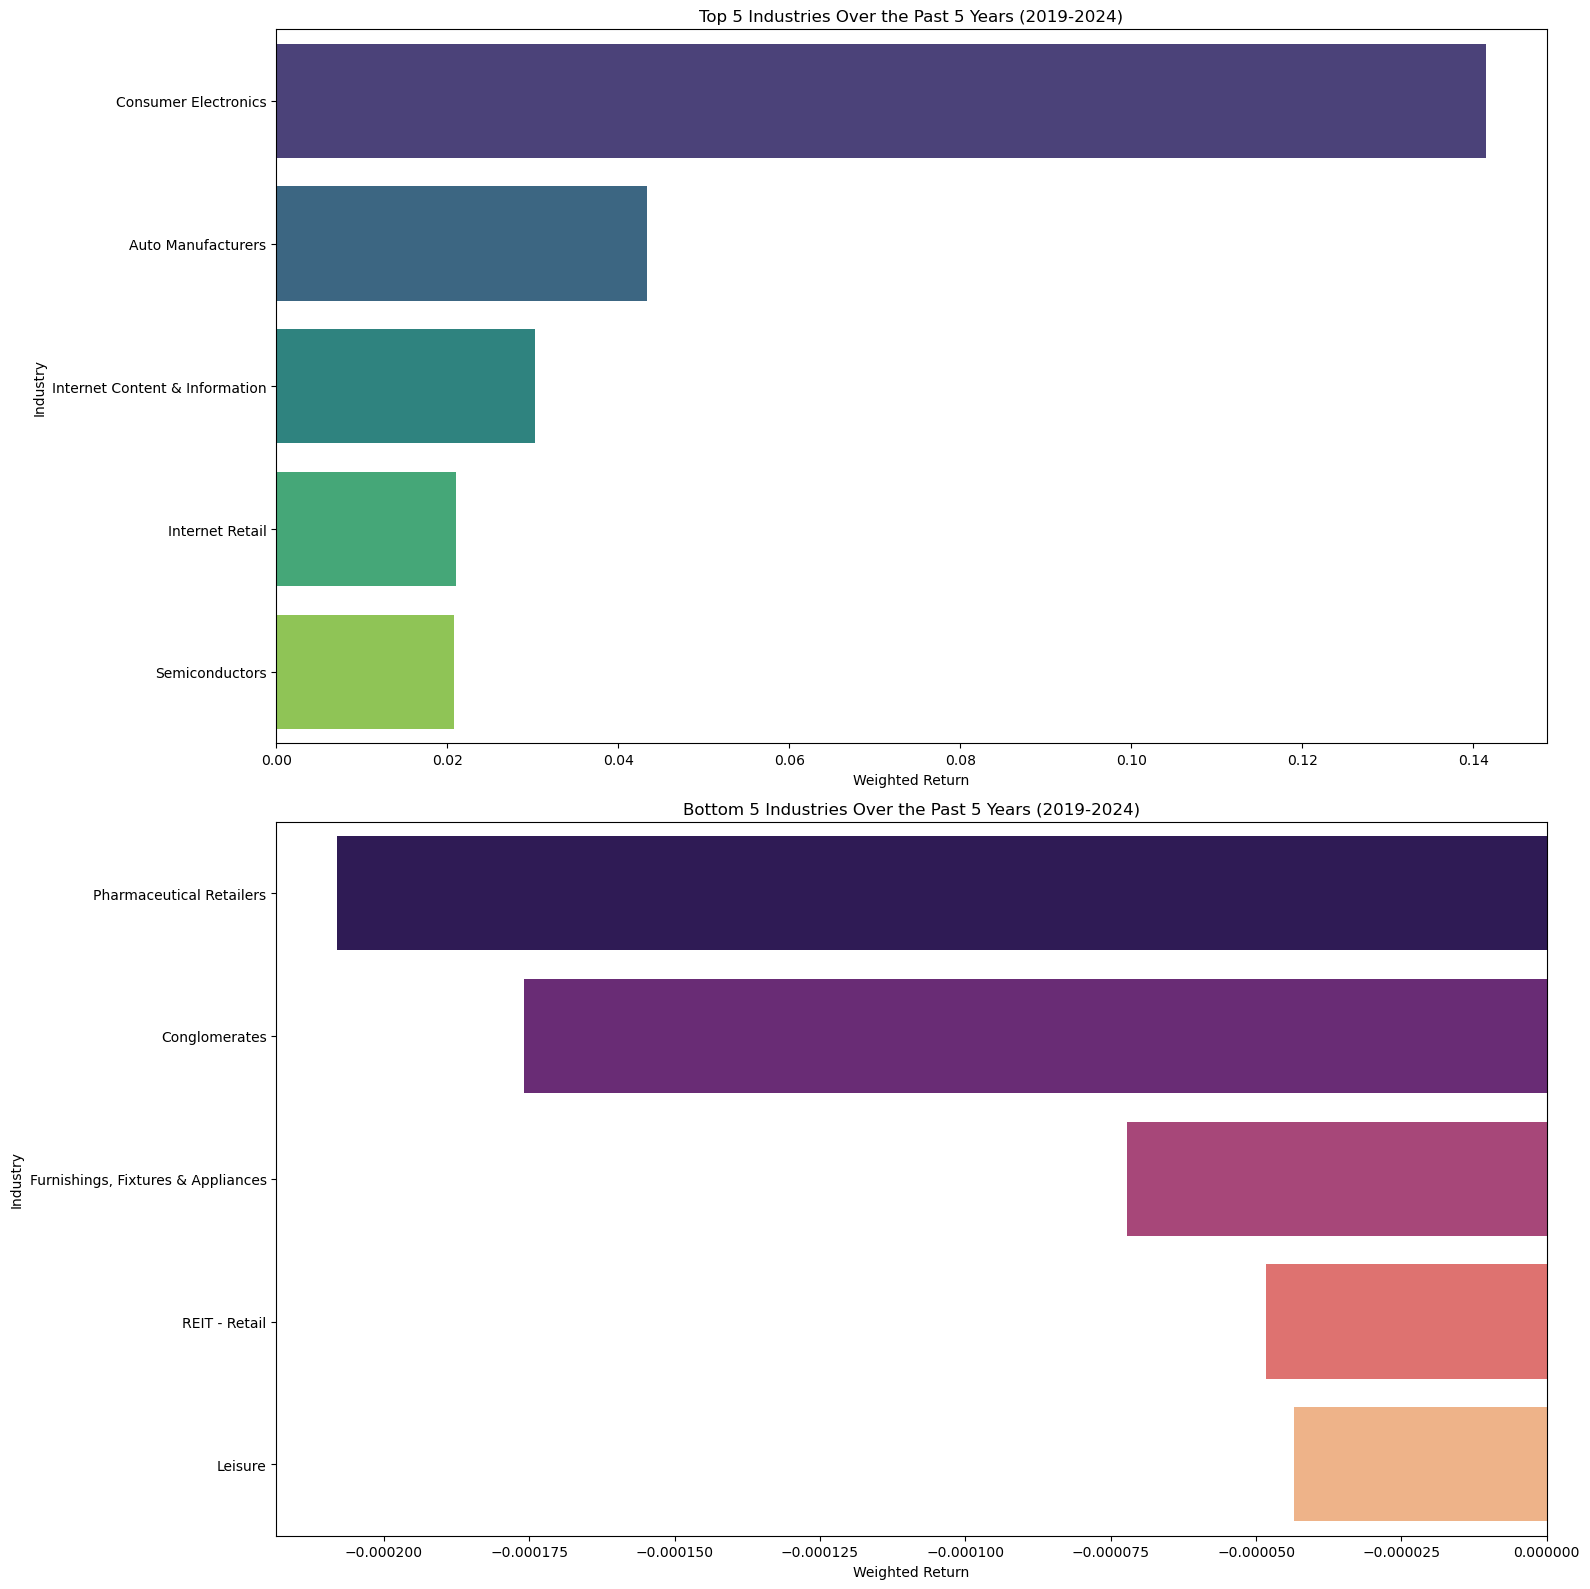

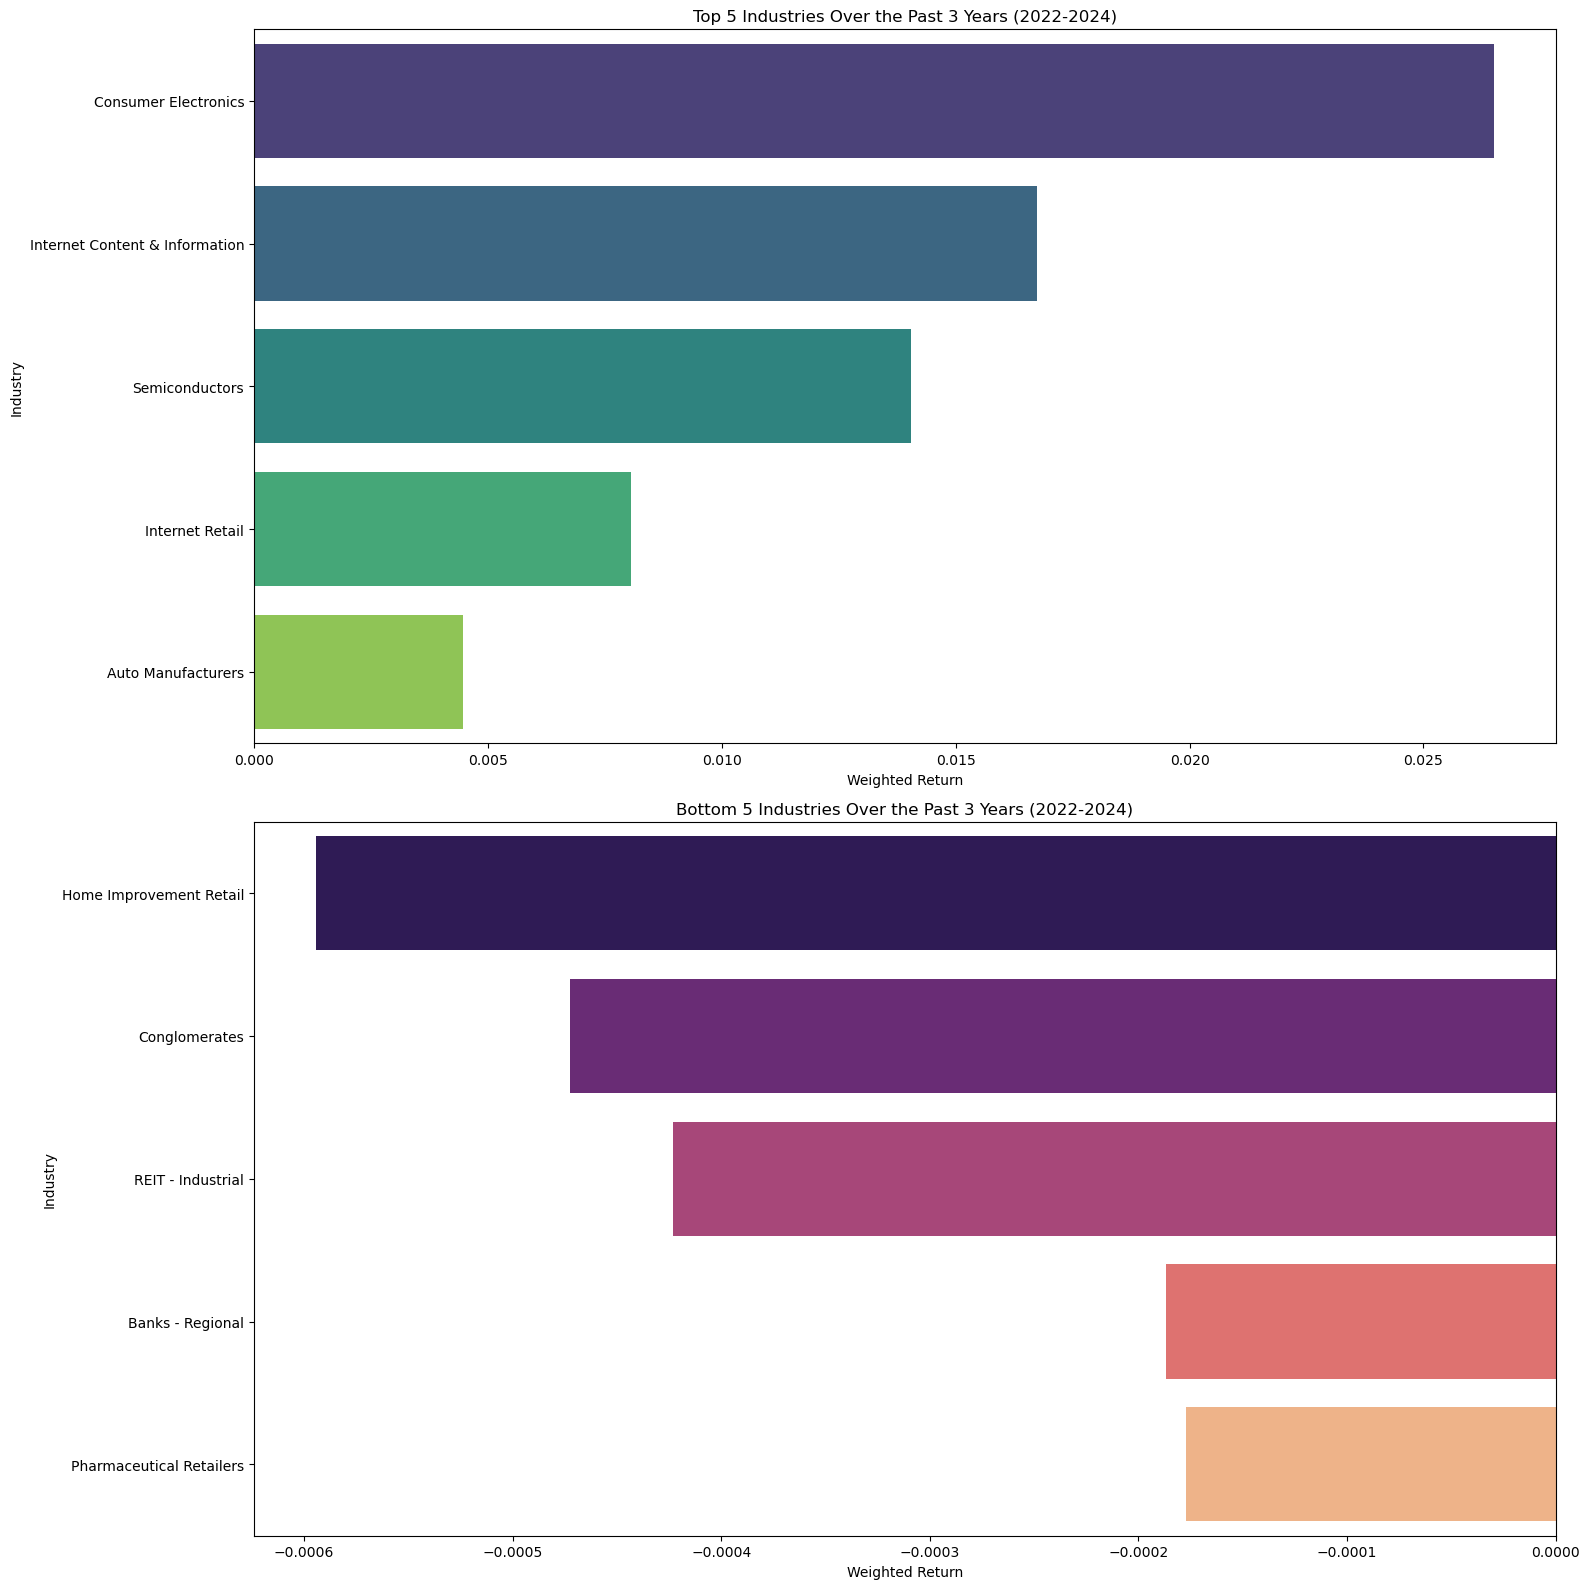

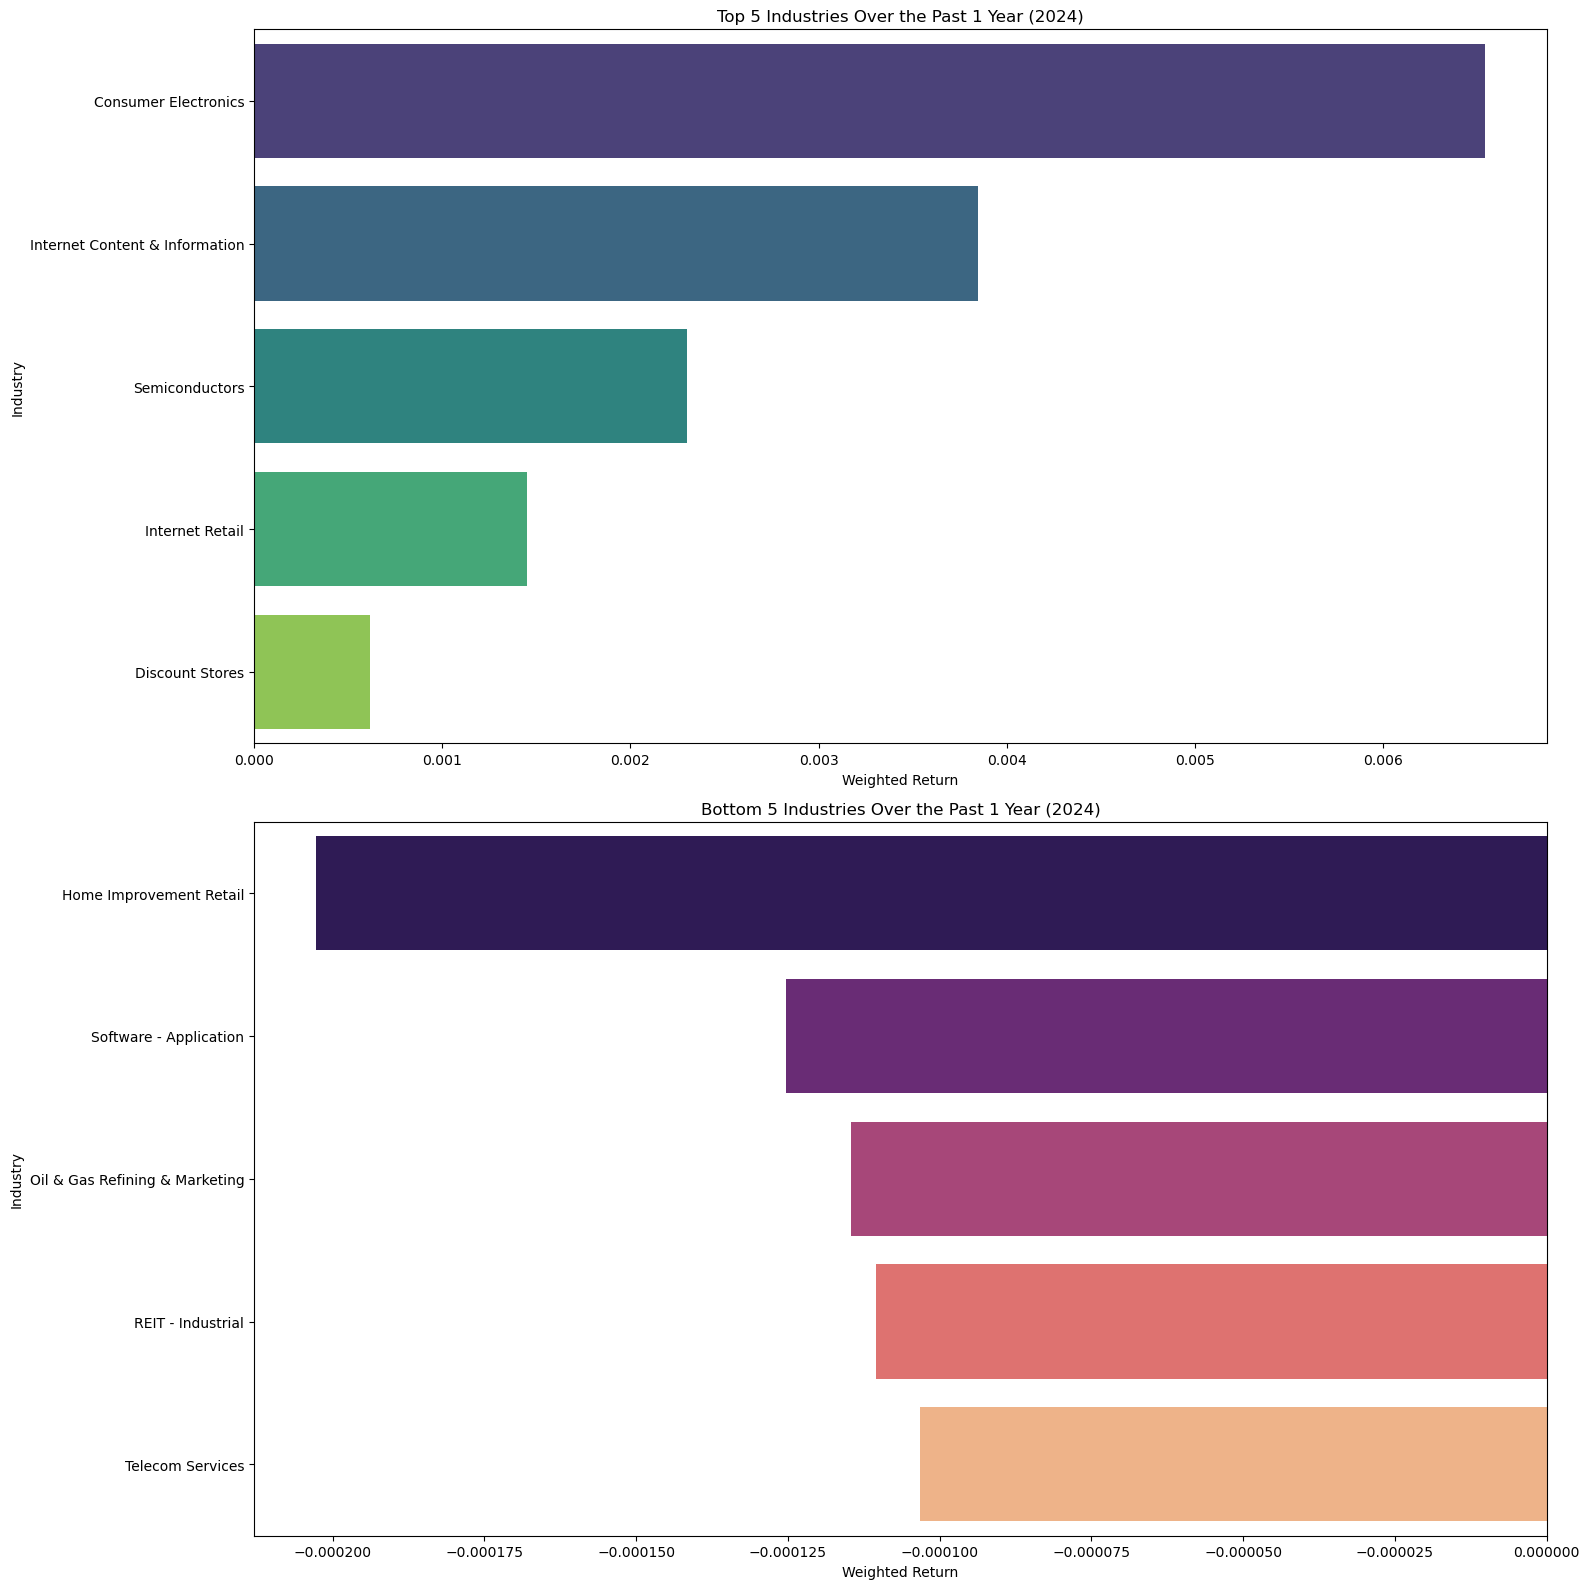

In [21]:
def visualize_industries(industry_performance, title, top_n=5):
    top_industries = industry_performance.nlargest(top_n, 'Weighted Return')
    bottom_industries = industry_performance.nsmallest(top_n, 'Weighted Return')

    fig, axes = plt.subplots(2, 1, figsize=(16, 16))

    sns.barplot(x='Weighted Return', y='Industry', data=top_industries, ax=axes[0], palette='viridis')
    axes[0].set_title(f'Top {top_n} Industries {title}')
    axes[0].set_xlabel('Weighted Return')
    axes[0].set_ylabel('Industry')

    sns.barplot(x='Weighted Return', y='Industry', data=bottom_industries, ax=axes[1], palette='magma')
    axes[1].set_title(f'Bottom {top_n} Industries {title}')
    axes[1].set_xlabel('Weighted Return')
    axes[1].set_ylabel('Industry')

    plt.tight_layout()
    plt.show()

# Visualize the top and bottom industries for each period separately
visualize_industries(industry_performance_five_years, 'Over the Past 5 Years (2019-2024)')
visualize_industries(industry_performance_three_years, 'Over the Past 3 Years (2022-2024)')
visualize_industries(industry_performance_one_year, 'Over the Past 1 Year (2024)')

In [52]:
# Ensure 'Industry' is merged correctly with the annual returns data frames
def merge_with_industry(df):
    return df.merge(companies_df[['Symbol', 'Industry']], on='Symbol', how='left')

# Merge 'Industry' column
annual_returns_five_years = merge_with_industry(annual_returns_five_years)
annual_returns_three_years = merge_with_industry(annual_returns_three_years)
annual_returns_one_year = merge_with_industry(annual_returns_one_year)

# Function to find top 10 stocks in each specified industry
def top_stocks_in_specific_industries(df, industries):
    top_stocks = {}
    for industry in industries:
        industry_stocks = df[df['Industry'] == industry].drop_duplicates('Symbol')
        top_stocks[industry] = industry_stocks.nlargest(10, 'Annual Return')
    return top_stocks

# Define the specific industries for each period
industries_five_years = ['Consumer Electronics', 'Auto Manufacturers', 'Internet Content & Information', 'Internet Retail', 'Semiconductors']
industries_three_years = ['Consumer Electronics', 'Internet Content & Information', 'Semiconductors', 'Internet Retail', 'Auto Manufacturers']
industries_one_year = ['Consumer Electronics', 'Internet Content & Information', 'Semiconductors', 'Internet Retail', 'Discount Stores']

# Find top 10 best-performing stocks in each specific industry
top_10_stocks_five_years = top_stocks_in_specific_industries(annual_returns_five_years, industries_five_years)
top_10_stocks_three_years = top_stocks_in_specific_industries(annual_returns_three_years, industries_three_years)
top_10_stocks_one_year = top_stocks_in_specific_industries(annual_returns_one_year, industries_one_year)

# Print the results
print("Top 10 Best-Performing Stocks in Each Top Industry Over the Past 5 Years (2019-2024):")
for industry, stocks in top_10_stocks_five_years.items():
    print(f"\nIndustry: {industry}")
    print(stocks[['Symbol', 'Annual Return']])

print("\nTop 10 Best-Performing Stocks in Each Top Industry Over the Past 3 Years (2022-2024):")
for industry, stocks in top_10_stocks_three_years.items():
    print(f"\nIndustry: {industry}")
    print(stocks[['Symbol', 'Annual Return']])

print("\nTop 10 Best-Performing Stocks in Each Top Industry Over the Past 1 Year (2024):")
for industry, stocks in top_10_stocks_one_year.items():
    print(f"\nIndustry: {industry}")
    print(stocks[['Symbol', 'Annual Return']])

Top 10 Best-Performing Stocks in Each Top Industry Over the Past 5 Years (2019-2024):

Industry: Consumer Electronics
   Symbol  Annual Return
12   AAPL        0.36246

Industry: Auto Manufacturers
     Symbol  Annual Return
2706   TSLA       0.319070
1080      F       0.014544
1254     GM      -0.010108

Industry: Internet Content & Information
     Symbol  Annual Return
1974   MTCH       0.409098
1266   GOOG       0.154177
1272  GOOGL       0.149361
1842   META       0.090376

Industry: Internet Retail
     Symbol  Annual Return
1038   ETSY       0.135923
918    EBAY      -0.001821
192    AMZN      -0.037743

Industry: Semiconductors
     Symbol  Annual Return
2568   SWKS       0.504591
1806   MCHP       0.397230
2106   NXPI       0.367242
2346   QCOM       0.347912
162     AMD       0.311869
2136     ON       0.281832
2352   QRVO       0.271539
1464   INTC       0.211547
2730    TXN       0.168419
1986     MU       0.167229

Top 10 Best-Performing Stocks in Each Top Industry Over th

In [58]:
import yfinance as yf

# Fetch daily stock prices for a given symbol
def fetch_daily_prices(symbols, start_date, end_date):
    prices = {}
    for symbol in symbols:
        stock = yf.Ticker(symbol)
        hist = stock.history(start=start_date, end=end_date)
        prices[symbol] = hist['Close']
    return prices

# Define the date range
start_date = '2019-01-01'
end_date = '2024-01-01'

# Fetch daily prices for top stocks in each period
symbols_five_years = [symbol for industry in top_10_stocks_five_years.values() for symbol in industry['Symbol']]
symbols_three_years = [symbol for industry in top_10_stocks_three_years.values() for symbol in industry['Symbol']]
symbols_one_year = [symbol for industry in top_10_stocks_one_year.values() for symbol in industry['Symbol']]

daily_prices_five_years = fetch_daily_prices(symbols_five_years, start_date, end_date)
daily_prices_three_years = fetch_daily_prices(symbols_three_years, start_date, end_date)
daily_prices_one_year = fetch_daily_prices(symbols_one_year, start_date, end_date)

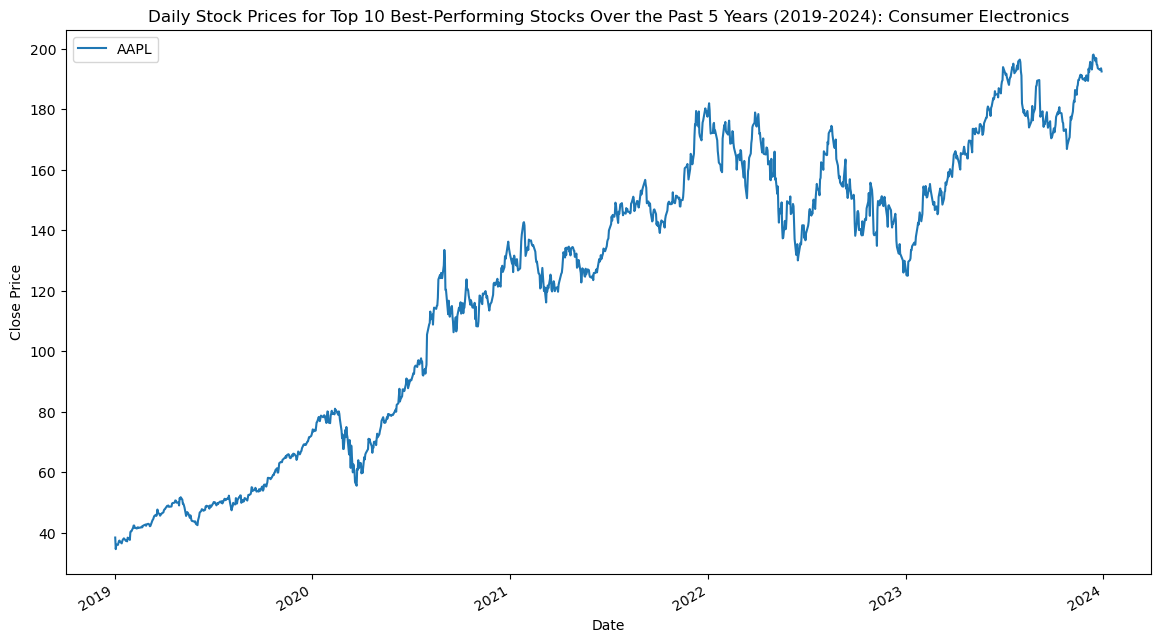

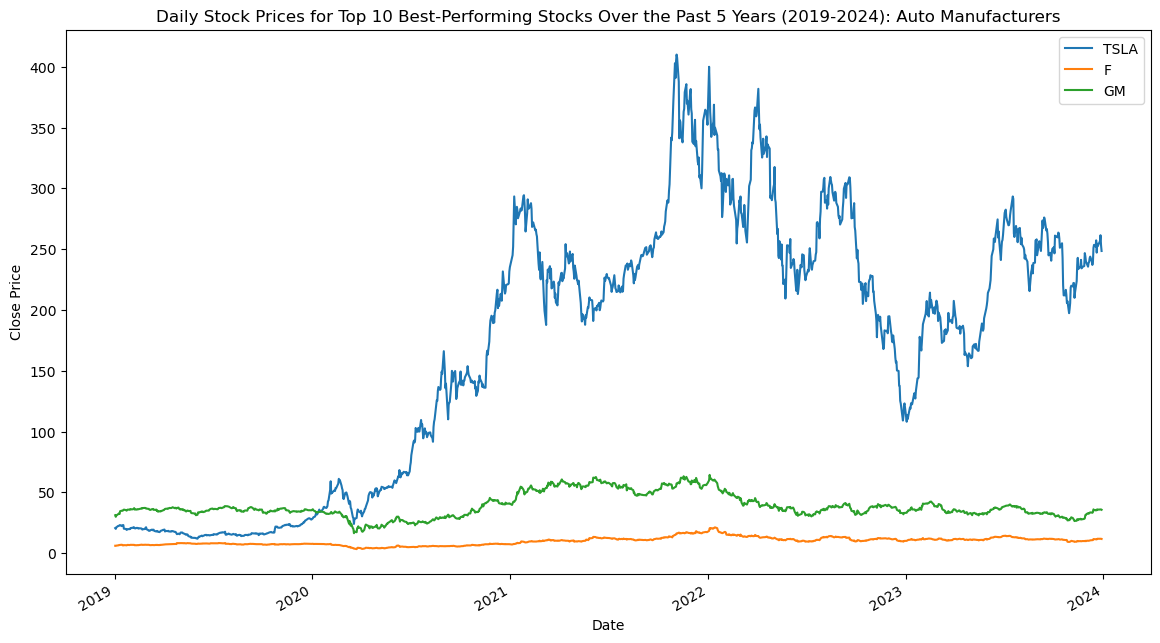

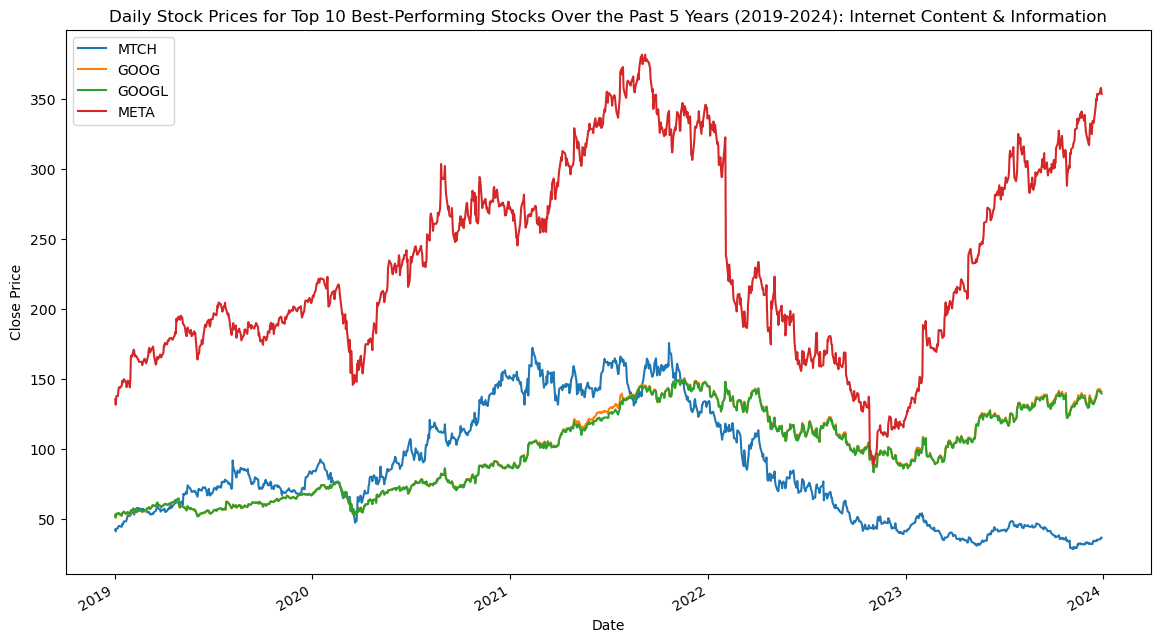

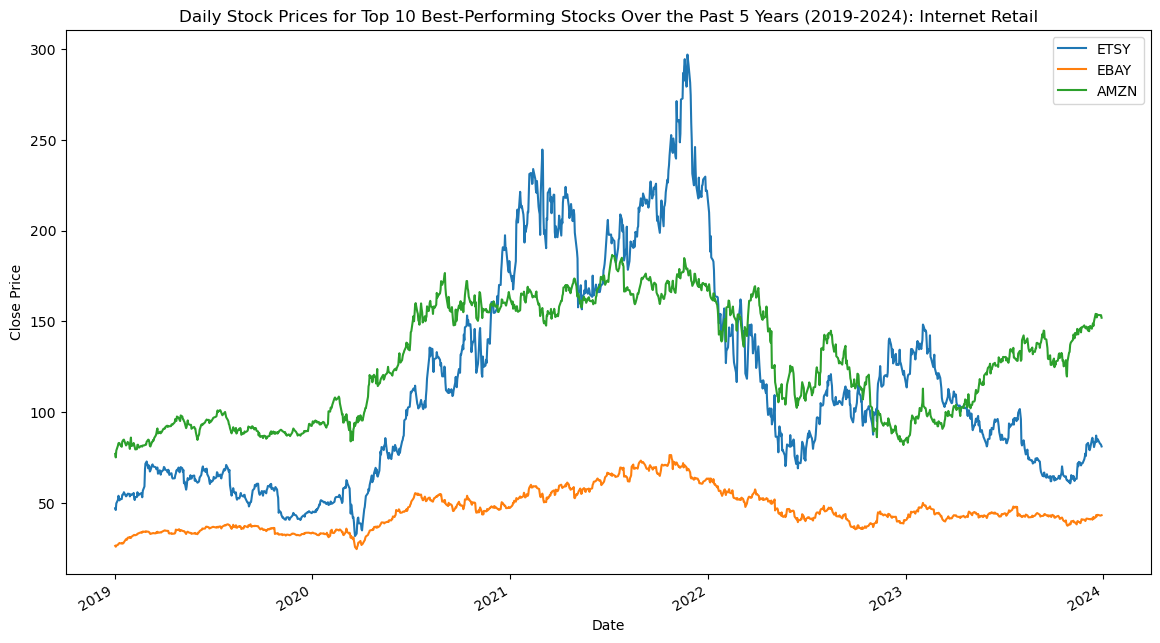

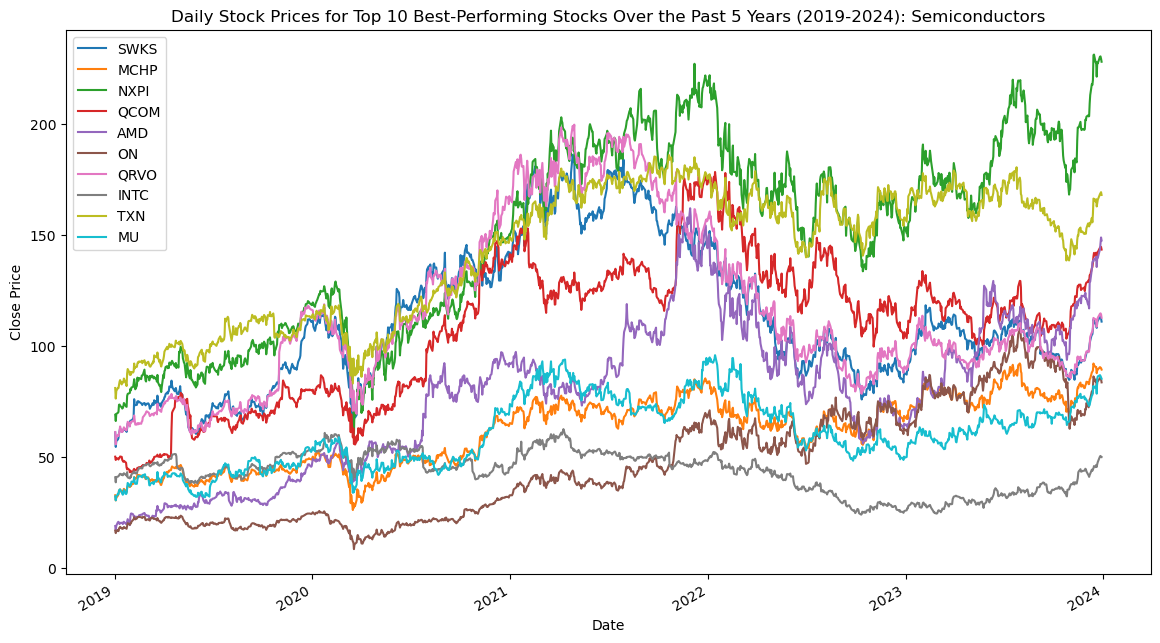

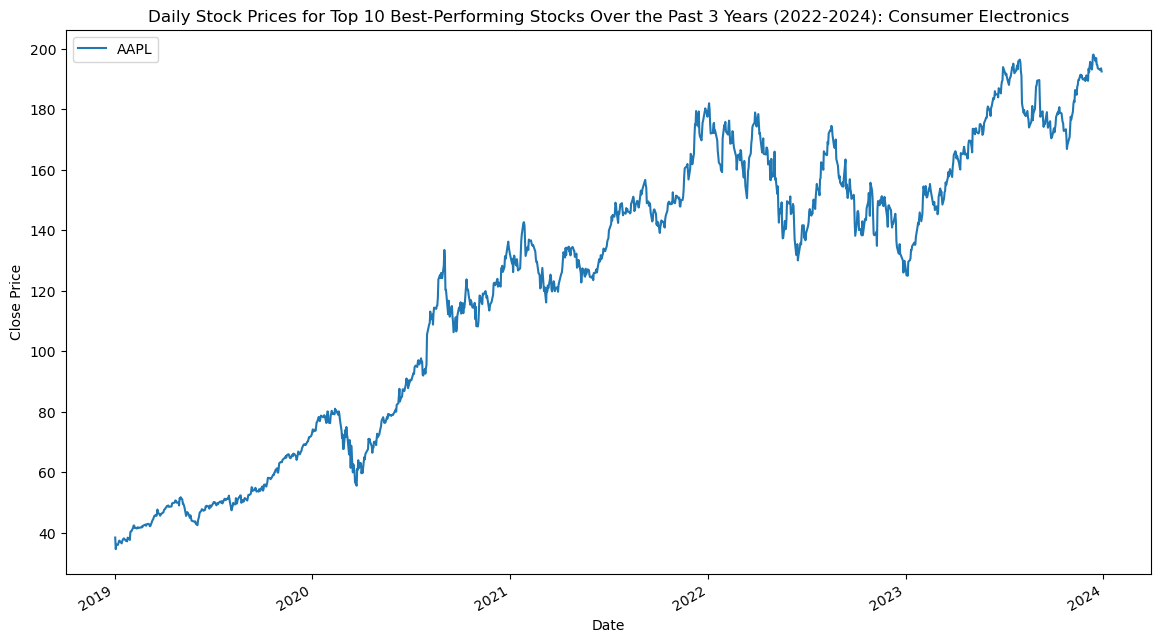

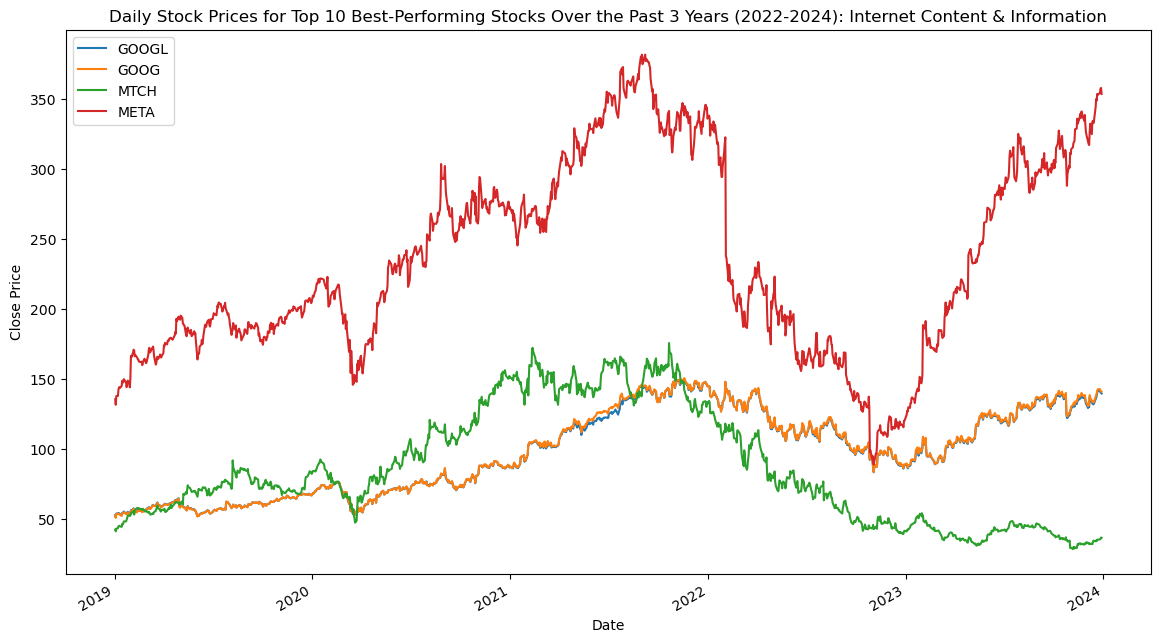

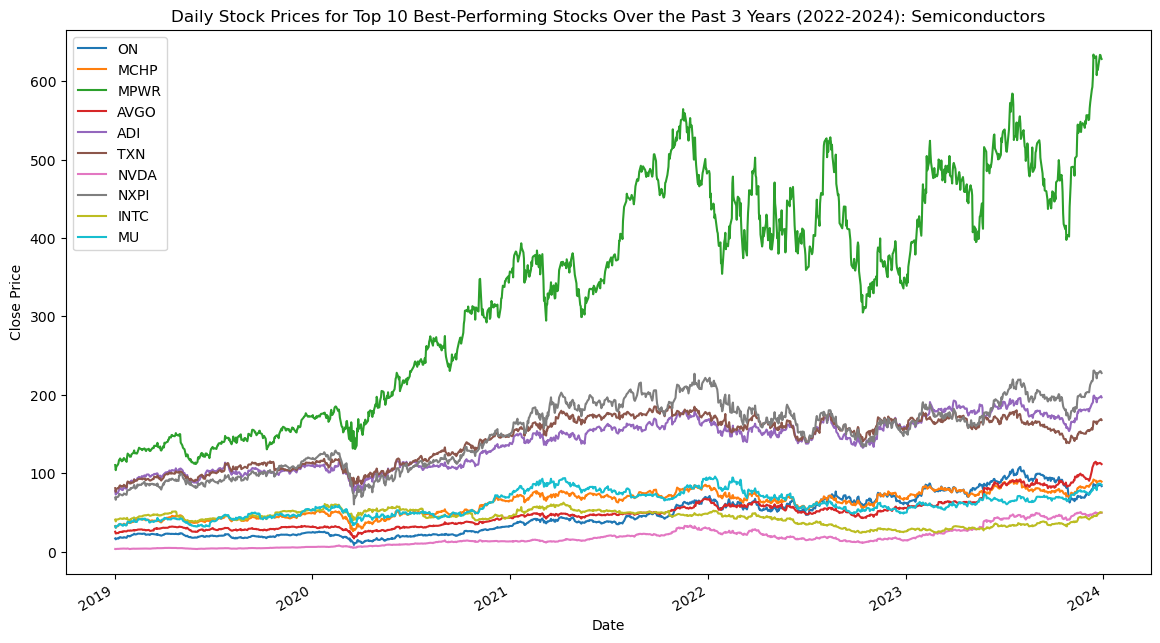

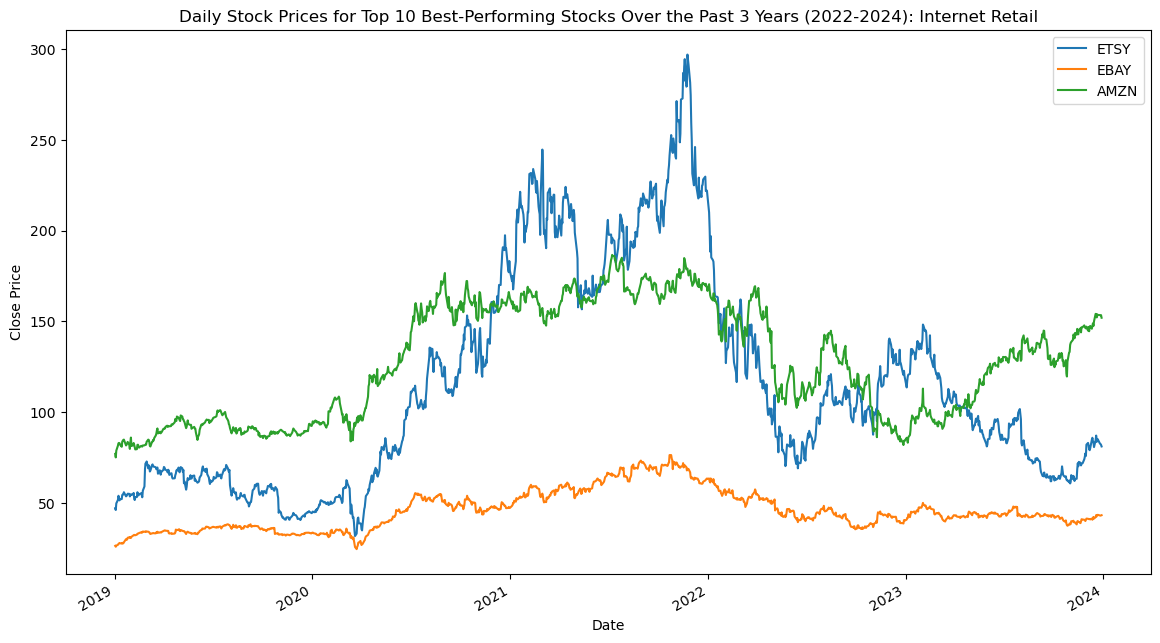

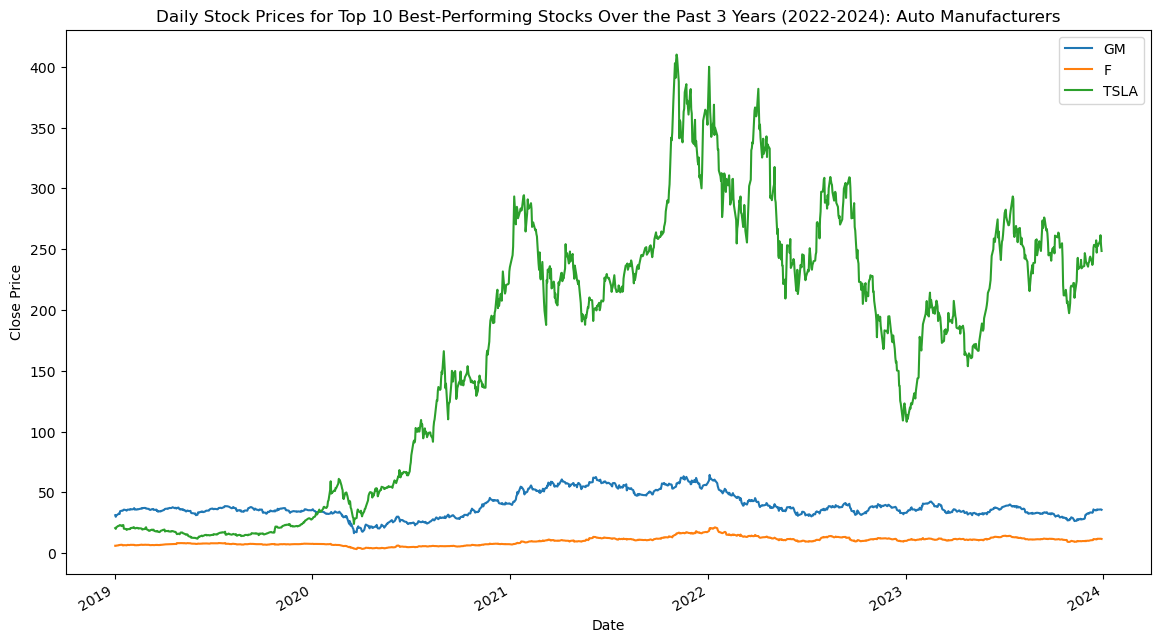

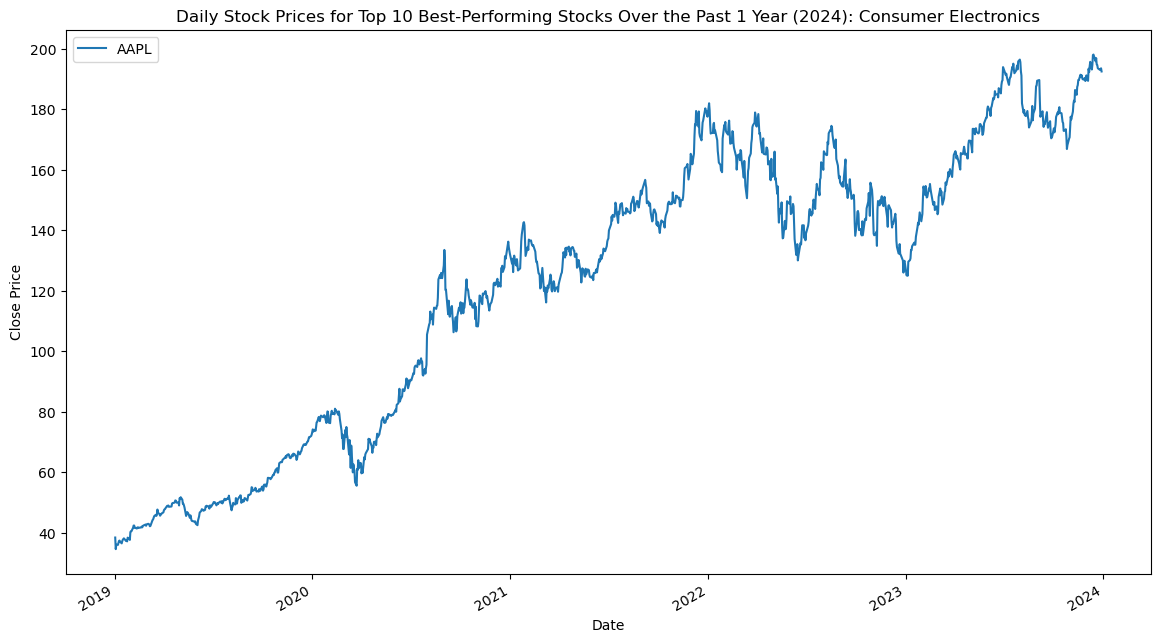

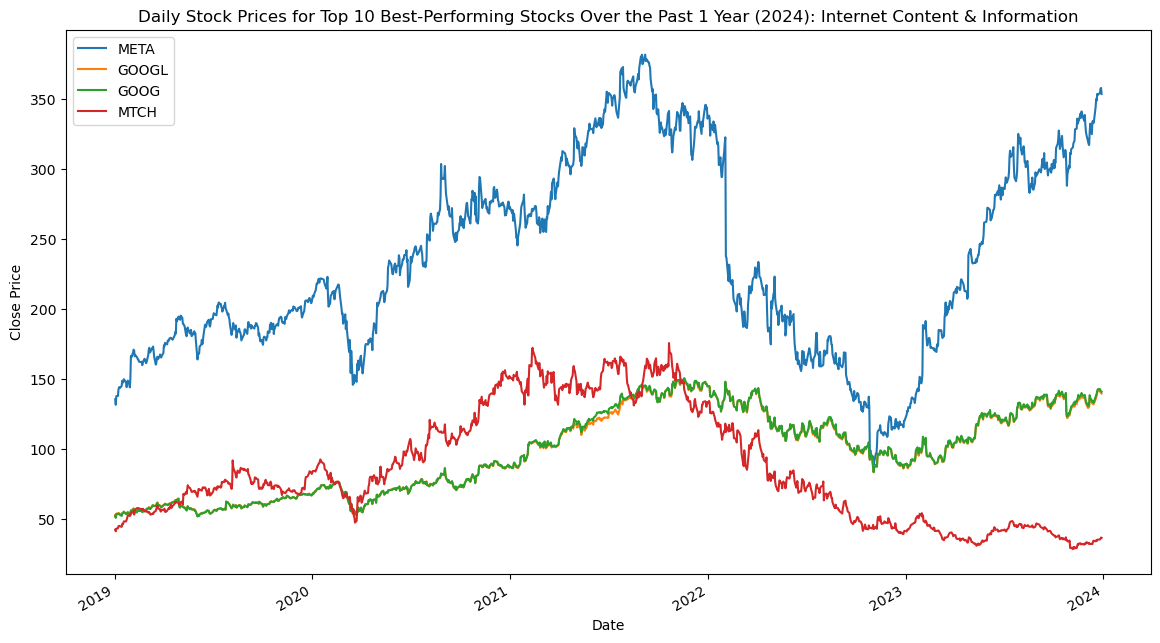

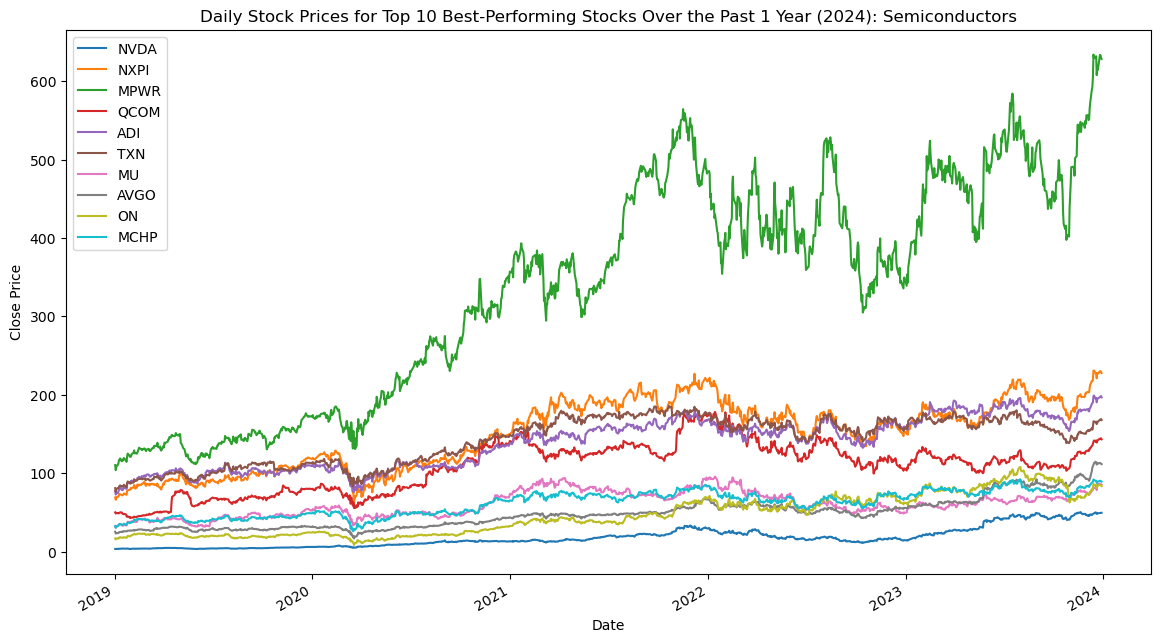

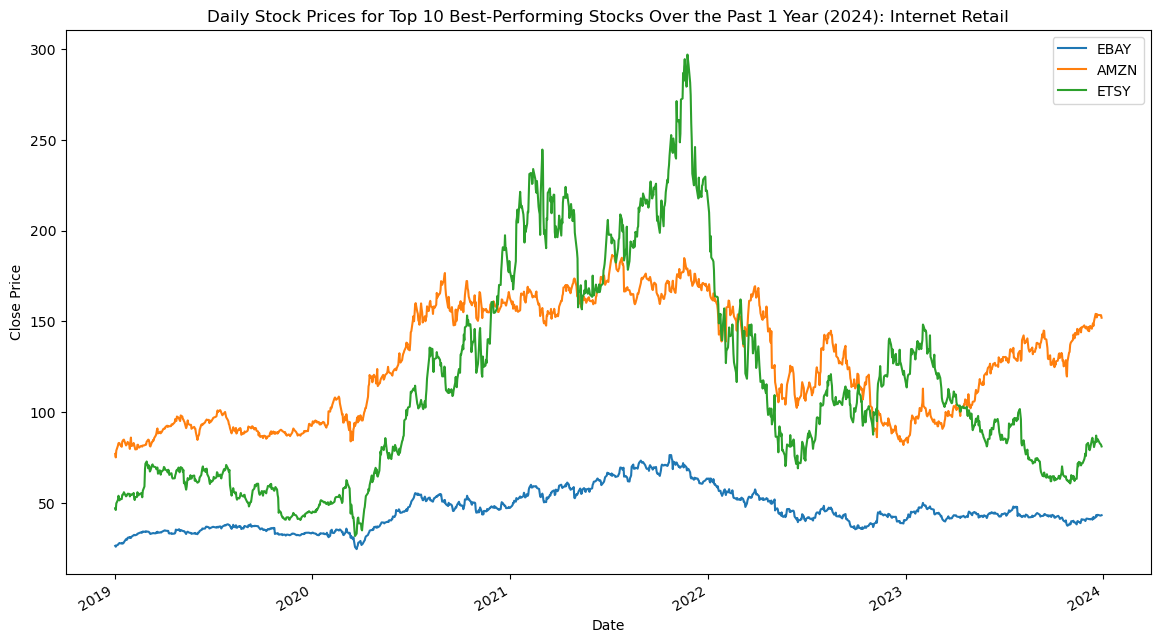

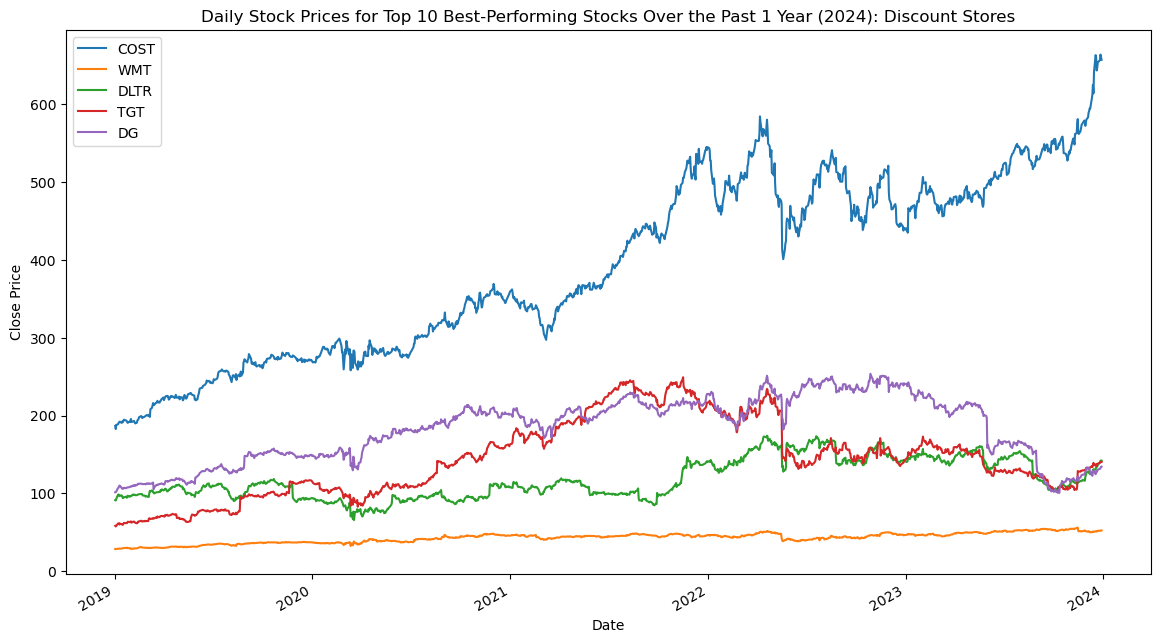

In [60]:
import matplotlib.pyplot as plt

# Fetch daily stock prices for a given symbol
def fetch_daily_prices(symbols, start_date, end_date):
    prices = {}
    for symbol in symbols:
        stock = yf.Ticker(symbol)
        hist = stock.history(start=start_date, end=end_date)
        prices[symbol] = hist['Close']
    return prices

# Define the date range
start_date = '2019-01-01'
end_date = '2024-01-01'

# Function to get unique stock symbols from top 10 stocks
def get_symbols(top_stocks):
    return [symbol for stocks in top_stocks.values() for symbol in stocks['Symbol']]

# Fetch daily prices for top stocks in each period
symbols_five_years = get_symbols(top_10_stocks_five_years)
symbols_three_years = get_symbols(top_10_stocks_three_years)
symbols_one_year = get_symbols(top_10_stocks_one_year)

daily_prices_five_years = fetch_daily_prices(symbols_five_years, start_date, end_date)
daily_prices_three_years = fetch_daily_prices(symbols_three_years, start_date, end_date)
daily_prices_one_year = fetch_daily_prices(symbols_one_year, start_date, end_date)

# Plot daily stock prices for top stocks in each industry
def plot_daily_prices_by_industry(top_stocks, daily_prices, title):
    industries = top_stocks.keys()
    for industry in industries:
        plt.figure(figsize=(14, 8))
        for symbol in top_stocks[industry]['Symbol']:
            if symbol in daily_prices:
                daily_prices[symbol].plot(label=symbol)
        plt.title(f'{title}: {industry}')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.legend()
        plt.show()

# Plot daily prices for top 10 best-performing stocks in each industry over the past 5 years
plot_daily_prices_by_industry(top_10_stocks_five_years, daily_prices_five_years, 'Daily Stock Prices for Top 10 Best-Performing Stocks Over the Past 5 Years (2019-2024)')

# Plot daily prices for top 10 best-performing stocks in each industry over the past 3 years
plot_daily_prices_by_industry(top_10_stocks_three_years, daily_prices_three_years, 'Daily Stock Prices for Top 10 Best-Performing Stocks Over the Past 3 Years (2022-2024)')

# Plot daily prices for top 10 best-performing stocks in each industry over the past 1 year
plot_daily_prices_by_industry(top_10_stocks_one_year, daily_prices_one_year, 'Daily Stock Prices for Top 10 Best-Performing Stocks Over the Past 1 Year (2024)')